In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import os

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,

    precision_score,
    recall_score
)
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
#path =r"C:\Users\gianf\Desktop\ETH\II_Semestre\ML4HC\ML4Healthcare\project2\task2\transfer_learning"
#os.chdir(path)

import warnings

from cnn_utils_transf import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)

from torch import Tensor

pd.set_option('display.max_columns', None)

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

N_EPOCHS=200


In [9]:
# Load data
#train_df = pd.read_csv(os.path.join(path, 'mitbih_train.csv'), header=None)
#test_df = pd.read_csv(os.path.join(path, 'mitbih_test.csv'), header=None)

train_df = pd.read_csv('../../data/mitbih_train.csv', header=None)
test_df = pd.read_csv('../../data/mitbih_test.csv', header=None)

In [10]:
train_df.iloc[:,-1].unique()

array([0., 1., 2., 3., 4.])

In [11]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

In [13]:
import matplotlib as plt
counts = [np.count_nonzero(y_train_full==0),
np.count_nonzero(y_train_full==1),
np.count_nonzero(y_train_full==2),
np.count_nonzero(y_train_full==3),
np.count_nonzero(y_train_full==4)]

<BarContainer object of 5 artists>

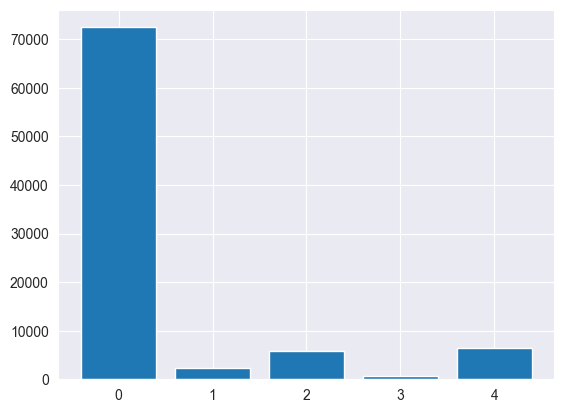

In [14]:
plt.pyplot.bar([0,1,2,3,4],counts)


Split into train and validation sets:

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=SEED
)

Moreover, to deal with the large class imbalance, which we discovered in our EDA, we will use SMOTE oversampling to balance the classes in the training set and provide some data augmentation.

In [16]:
sm = SMOTE(random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [17]:
train_loader = DataLoader(
        PTB_Dataset(X_train, y_train),
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
    )
val_loader = DataLoader(
    PTB_Dataset(X_val, y_val),
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

test_loader = DataLoader(
    PTB_Dataset(X_test, y_test),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

# The CNN:

## CNN Class Definition:

In [19]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed

class CNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        # Initial convolution layer
        # self.conv = nn.Conv1d(
        #     in_channels=in_channels,
        #     out_channels=16,
        #     #kernel_size=(3, 3),
        #     kernel_size=3,
        #     padding='same',
        #     bias=False
        # )
        # self.bn = nn.BatchNorm1d(16)
        # self.relu = nn.ReLU()
        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)


        #Out features from the 4 blocks of residual layers: 128


        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        #self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Sequential(
            nn.Linear(1280, 16),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(16, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]



        # x = self.conv(x)
        # x = self.bn(x)
        # x = self.relu(x)

        # #print("Shape after convolution and activation:", x.shape)

        # x = self.flatten(x)
        # #print("Shape after flattening:", x.shape)
        # x = self.dropout(x)
        # x = self.linear(x)
        # #print("Shape after linear layer:", x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)

        x = self.flatten(x)
        x = self.fc(x)
        return x

    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(SEED)
model=CNN(classes_num=5, in_channels=1)

## Training the CNN:

In [20]:
model = model.to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")

C:\Users\gianf\anaconda3\envs\ml4hc\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [13]:
model = train_and_validate(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = train_loader,
    val_loader = val_loader,
    best_model_path = "../weights/cnn_mitbih.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

  0%|          | 0/200 [00:00<?, ?it/s]/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_

Early stopping at epoch 40. Best score was 0.9347 in epoch 3.


In [22]:
model = CNN(classes_num=5, in_channels=1)
model.load_state_dict(torch.load("../weights/cnn_mitbih.pth", map_location = torch.device(DEVICE)))
model.to(DEVICE)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool1d(output_size=10)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f

## Evaluating the CNN:

In [23]:
model_probs, y_preds, y_true, test_loss = test(
    model = model,
    criterion = criterion,
    test_loader = test_loader,
    device = DEVICE
)

Test loss: 0.0005, Test accuracy: 0.9683, Test balanced accuracy: 0.9220S


## Metrics

The metrics reported in the following part of the code are inspired by: https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

In the following chunck we are plotting the Confusion Matrix. In this case we have on the diagonal the number of observation that are correctly classifed, while on the off diagonal we represent the number of observation that are classified wrongly.

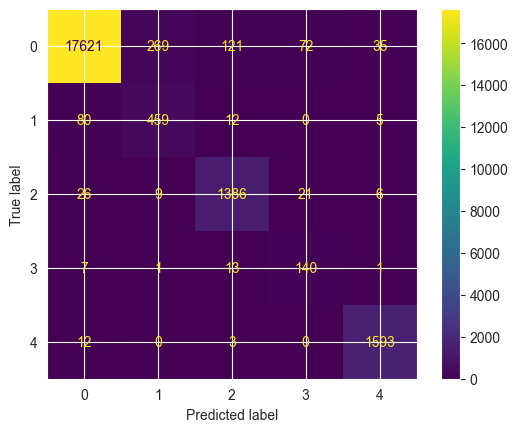

In [27]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()

***In the following part we calculate differents indexes to evaluate the perfomance of the model***

**Accuracy**: it is astraightforward metrics, and it describe how accurate the model is. In this case a value of 0.9814, suggest that the models has good prediction capability. The trade off of this metric is that it doesn't provide an estimate of the overall model quality, in particular it disregards class inbalance. In fact can happen that the model is very good at predicting the majority class, but very poor at predicting the minority class.

In [29]:
accuracy_score(y_preds, y_true)

0.9683446007674036

To overcome the poor capability of the accuracy to deal with class inbalance, we emploied the use of other possible metrics such as precision, recall and balanced accuracy. 

In [30]:
# Calculate precision for each class
precision = precision_score(y_true, y_preds, average=None)

# Calculate recall for each class
recall = recall_score(y_true, y_preds, average=None)

# Calculate macro-average precision and recall
macro_precision = precision_score(y_true, y_preds, average='macro')
macro_recall = recall_score(y_true, y_preds, average='macro')



**Precision**: In multi-class classification, precision correspond to the fraction of observations correctly classifed as being of a certain class over all the observations that the model predict to belong to that class. So with this metric we can measure the model's ability to identify instances of a particular class correctly. It is possible to notice that for certain classes the precision is higher compared to others.

In [31]:
print("Precision for each class:", precision)


Precision for each class: [0.99295616 0.62195122 0.9029316  0.60085837 0.97134146]


**Recall**:  In multi-class classification, precision correspond to the fraction of observations correctly classifed as being of a certain class over all the observations that belong to that class. So with this metric we can measure the model's ability to identify all instances of a particular class correctly.

In [32]:
print("Recall for each class:", recall)


Recall for each class: [0.97256872 0.82553957 0.95718232 0.86419753 0.99067164]


**Macro-average precision/recall**: The idea behind this metric is that, instead of having the precision for every class, it is possible to reduce them into one "average" metric. In this case we opted for a Macro-averaging precision and Macro-averagin racall. The reason we emploied the "Macro-average" is that it gives equal weight to each class, regardless of the number of instances.

In [33]:
print("Macro-average precision:", macro_precision)


Macro-average precision: 0.81800776145024


In [34]:
print("Macro-average recall:", macro_recall)

Macro-average recall: 0.9220319555272789


**Balanced Accuracy**: This metric is the average of recall obtained on each class. It is a good metric to use when the classes are imbalanced. In this case we have a value of 0.9339, which is very similar to the accuracy. This is due to the fact that the classes are balanced.

In [35]:
balanced_accuracy_score(y_true, y_preds)


0.9220319555272789

In [37]:
f1 = f1_score(y_true, y_preds, average="macro")
f1

0.86222455244643

In [38]:
f1_none = f1_score(y_true, y_preds, average=None)
f1_none

array([0.9826567 , 0.70942813, 0.92926584, 0.70886076, 0.98091133])